In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [13]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2024-12-20 08:28:46--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.2’

cats_and_dogs.zip.2 100%[===================>]  67.43M   187MB/s    in 0.4s    

2024-12-20 08:28:47 (187 MB/s) - ‘cats_and_dogs.zip.2’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [21]:
# 3 correctly classifies images of cats and dogs at least 63% of the time
rescale = 1.0/255.0

train_image_generator = ImageDataGenerator(rescale=rescale)
validation_image_generator = ImageDataGenerator(rescale=rescale)
test_image_generator = ImageDataGenerator(rescale=rescale)

train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size, directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size, directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(
    batch_size=batch_size, directory=PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes=['test'], shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

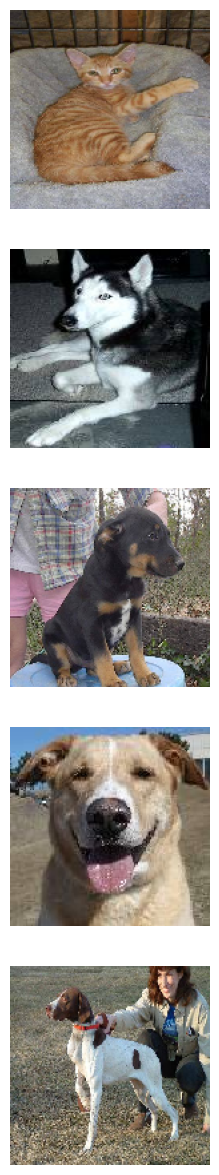

In [22]:
# 4 Do not edit:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [23]:
# 5 Recreate the train_image_generator using ImageDataGenerator.
train_image_generator = ImageDataGenerator(
    rescale=rescale,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 # ADDED
)

# Add 4-6 random transformations as arguments to ImageDataGenerator. Make sure to rescale the same as before.

Found 2000 images belonging to 2 classes.


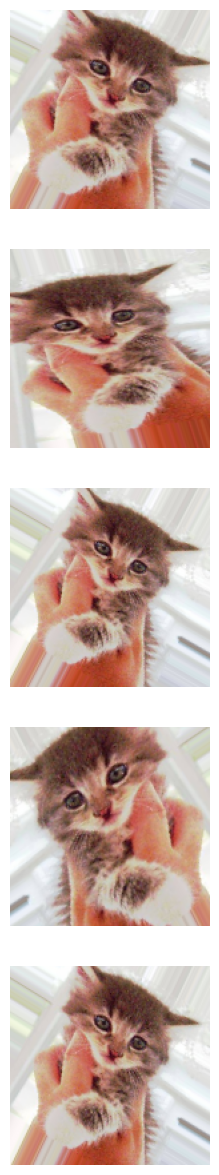

In [24]:
# 6 Do not edit:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [25]:

# 7 Use Keras Sequential model for  the neural network that outputs class probabilities
model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(64),
    Dense(2)
    # Dense(512, activation='relu'),
    # Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # FIXED
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       2,367,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,460,930 (9.39 MB)

 Trainable params: 2,460,930 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# 8 Use the fit method on your model to train the network.
# Train model
history = model.fit(
    x=train_data_gen,
    steps_per_epoch=(total_train // batch_size),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=(total_val // batch_size)
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4991 - loss: 1.2800 - val_accuracy: 0.5067 - val_loss: 0.6826
Epoch 2/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.4531 - loss: 0.6988

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.4531 - loss: 0.6988 - val_accuracy: 0.4808 - val_loss: 0.6902
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 631ms/step - accuracy: 0.5484 - loss: 0.6898 - val_accuracy: 0.4978 - val_loss: 0.6865
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5078 - loss: 0.6780 - val_accuracy: 0.5192 - val_loss: 0.6694
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 714ms/step - accuracy: 0.5276 - loss: 0.6758 - val_accuracy: 0.5915 - val_loss: 0.6514
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5078 - loss: 0.6827 - val_accuracy: 0.5962 - val_loss: 0.6576
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 689ms/step - accuracy: 0.6057 - loss: 0.6559 - val_accuracy: 0.6350 - val_loss: 0.6332
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6625 - loss: 0.6522 - val_accuracy: 0.6154 - val_loss: 0.6411
Epoch 9/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 611ms/step - accuracy: 0.6493 - loss: 0.6336 - val_accuracy: 0.6429 - val_

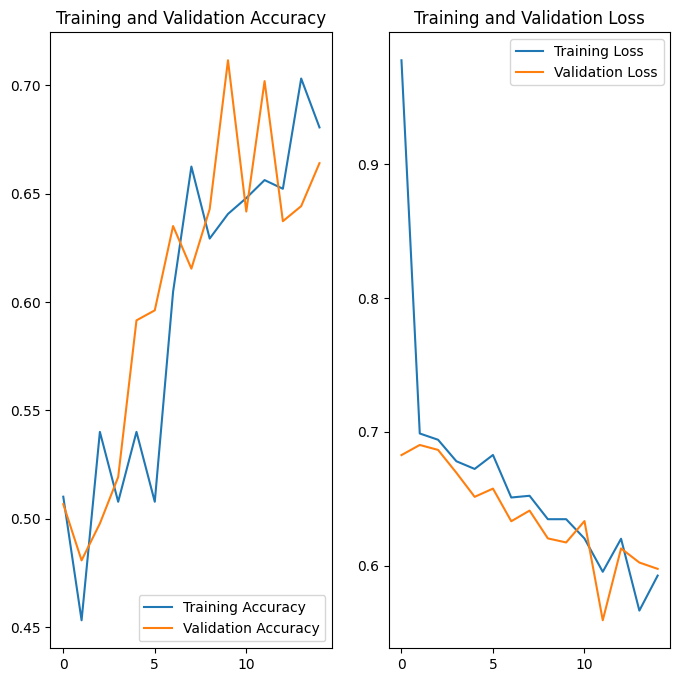

In [28]:
# 9 Do not edit:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# 10
# Generate predictions for the test dataset
test_images,_ = next(test_data_gen)
probabilities = np.argmax(model.predict(test_data_gen), axis=-1) # FIXED

In [31]:
# 11 Do not edit:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 66.0% of the images of cats and dogs.
You passed the challenge!
